# Model Training and Selection
---
Training and evaluati

In [1]:
import sys
sys.path.append('/global/home/users/alexandregeorges/Chapter1/')

from codebase.params import *

import os, pickle, itertools, glob, re, datetime, copy

from joblib import dump, load

import cv2 as cv

import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import rioxarray as rxr
import earthpy.plot as ep

import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import colors as colors_mat

from tqdm.notebook import tqdm
from pyproj import CRS

In [2]:
from sklearn.ensemble import  HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import SGDClassifier

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

from sklearn.model_selection import GridSearchCV

## Data Access

In [36]:
def paths_to_datetimeindex(list):
    pattern = PATTERN_REGEX
    new_list = []
    for item in list:
        time = re.search(pattern, item).group(1)
        time = datetime.strptime(time, '%m-%d-%Y').date()
        new_list.append(time)
    return new_list

Loading observations from each into xarray dataset and dict

In [37]:
site_codes = ['CCHT', 'GPHT', 'CRTT'] #CCHT, CRTT, GPHT

In [38]:
sites_data = {}
for code in site_codes:
    site_files = DOWNLOAD_DIR_ROOT + 'TRAINING/' + code + '/' + '*.tif'
    # Getting list of available observation dates from desired sites
    site_dates = [i.strftime('%m-%d-%Y') for i in paths_to_datetimeindex(glob.glob(site_files))]
    site_dates_xr = xr.Variable('Observation Date', site_dates)
    # Putting observations in xarray
    site_obs = [rxr.open_rasterio(entry).squeeze() for entry in glob.glob(site_files)]
    site_ds = xr.concat(site_obs, dim=site_dates_xr).to_dataset(dim='Observation Date')
    # Getting Training Labels from desired sites
    labels_dir = 'datasets/Shapefiles/' + code + '_training.shp'
    site_labels = gpd.read_file('../' + labels_dir)
    # Dropping any possible NaNs from labels
    site_labels = site_labels.dropna(axis=0, how='any')

    sites_data[code] = {'dataset': site_ds, 'dates': site_dates, 'labels': site_labels}

In [39]:
sites_data['CCHT']['dataset']

<xarray.Dataset>
Dimensions:      (band: 7, y: 2312, x: 7070)
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7
  * x            (x) float64 8.019e+05 8.019e+05 ... 8.231e+05 8.231e+05
  * y            (y) float64 2.186e+06 2.186e+06 ... 2.179e+06 2.179e+06
    spatial_ref  int64 0
Data variables:
    07-24-2023   (band, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    08-31-2023   (band, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    08-29-2023   (band, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    09-03-2023   (band, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    08-13-2023   (band, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    08-05-2023   (band, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    09-08-2023   (band, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    07-31-2023   (band, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    08-12-2023   (band, y, x) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     nan
    scale_factor:   1.0
    add_offset:     0.0

Quick visualisation

In [40]:
ccht = sites_data['CCHT']
initial_train = ccht['dataset'][ccht['dates'][0]]

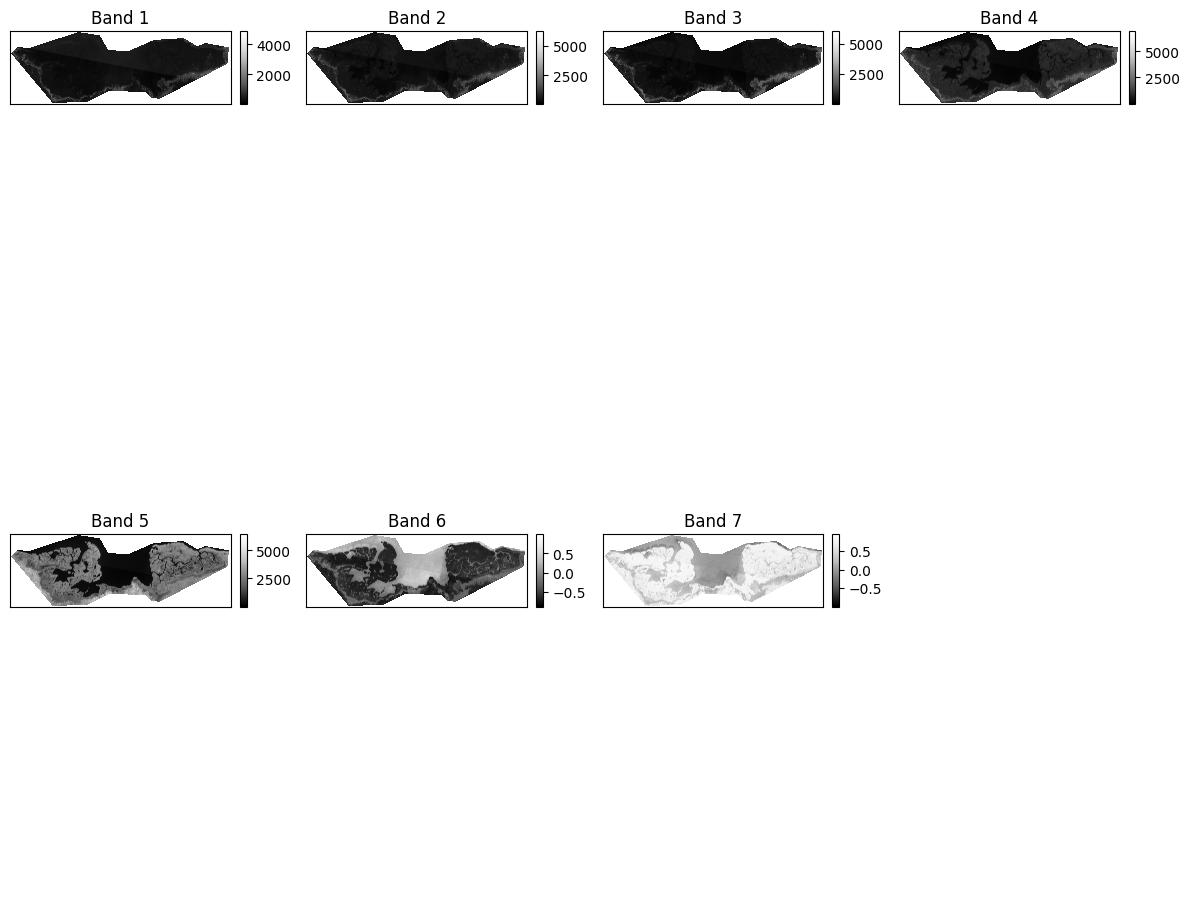

In [41]:
band_titles = ['Blue', 'Green', 'Red', 'RedEdge', 'NIR', 'NDWI', 'NDVI']
ep.plot_bands(initial_train, cols=4);

## Data Preprocessing

Importing and Formating Training Labels

In [42]:
new_crs = CRS.from_epsg(32618)

In [43]:
for code in site_codes:
    training_labels = sites_data[code]['labels']
    training_labels['Class'].replace('Cropland', 0, inplace=True)
    training_labels['Class'].replace('Mangrove', 1, inplace=True)
    training_labels['Class'].replace('Mudflat', 2, inplace=True)
    training_labels['Class'].replace('Open_Water', 3, inplace=True)
    training_labels['Class'].replace('Open_water_and_Intertidal_zone', 3, inplace=True)
    training_labels['Class'].replace('Open_Water_and_Mudflat_and_Intertidal_zone', 3, inplace=True)
    training_labels['Class'].replace('Other_Vegetation', 0, inplace=True)
    training_labels['Class'].replace('Urban', 4, inplace=True)
    training_labels.rename(columns={'Class' : 'id'}, inplace=True)
    sites_data[code]['labels'] = sites_data[code]['labels'].to_crs(new_crs)

Masking Water and Urban areas using Indices

In [44]:
for code in site_codes:
    site_ds_masked = copy.deepcopy(sites_data[code]['dataset'])
    for time in sites_data[code]['dates']:
        obs = site_ds_masked[time]
        ndvi_copy = obs[-1].copy()
        ndwi_copy = obs[-2].copy()
        for i,band in enumerate(obs):
            # Masking open water out of site
            new_band = np.ma.masked_where(ndwi_copy >= 0.2, band)
            # Masking non-vegetation out of site
            new_band = np.ma.masked_where(ndvi_copy <= 0.2, new_band)
            site_ds_masked[time][i] = new_band
    sites_data[code]['dataset'] = site_ds_masked

In [45]:
test_vis = sites_data['CCHT']['dataset'][sites_data['CCHT']['dates'][0]]

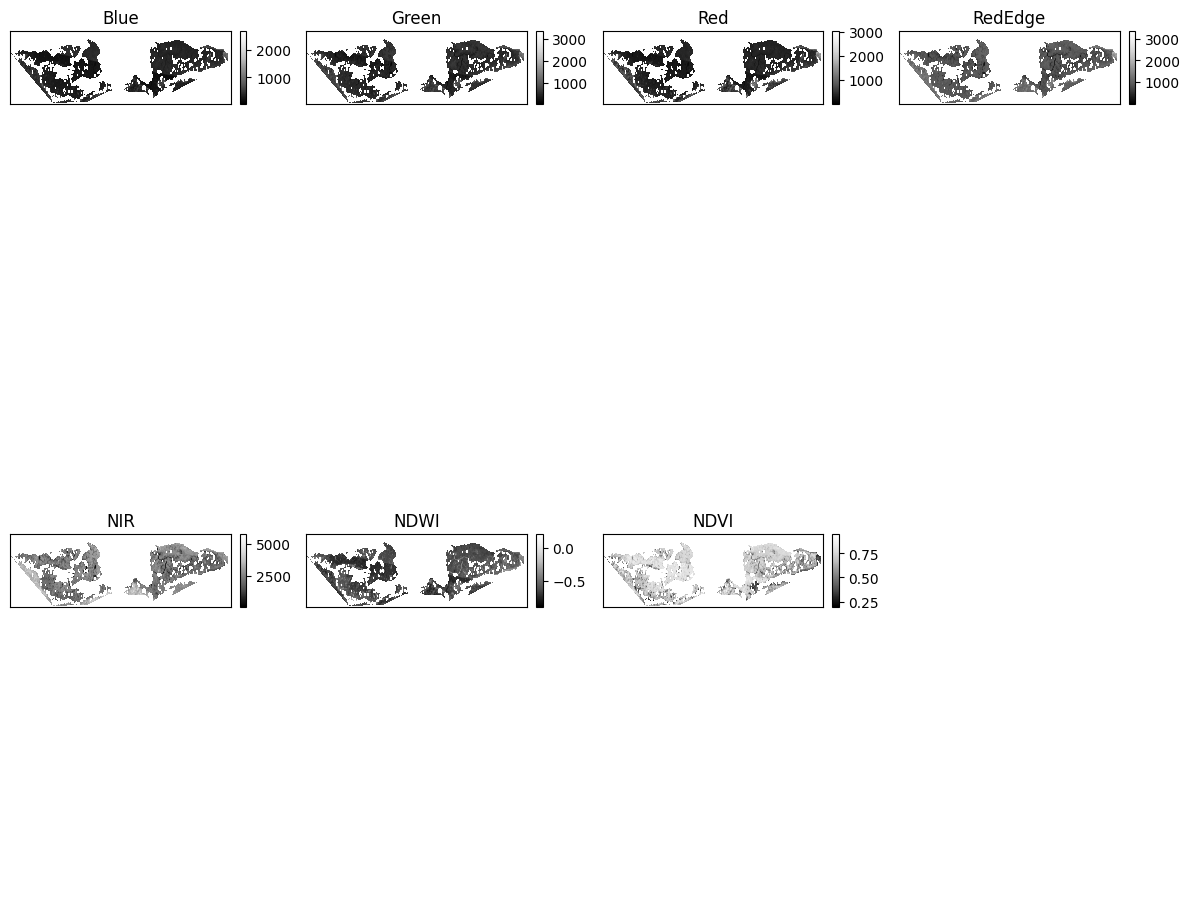

In [46]:
band_titles = ['Blue', 'Green', 'Red', 'RedEdge', 'NIR', 'NDWI', 'NDVI']
ep.plot_bands(test_vis, cols=4, title=band_titles);

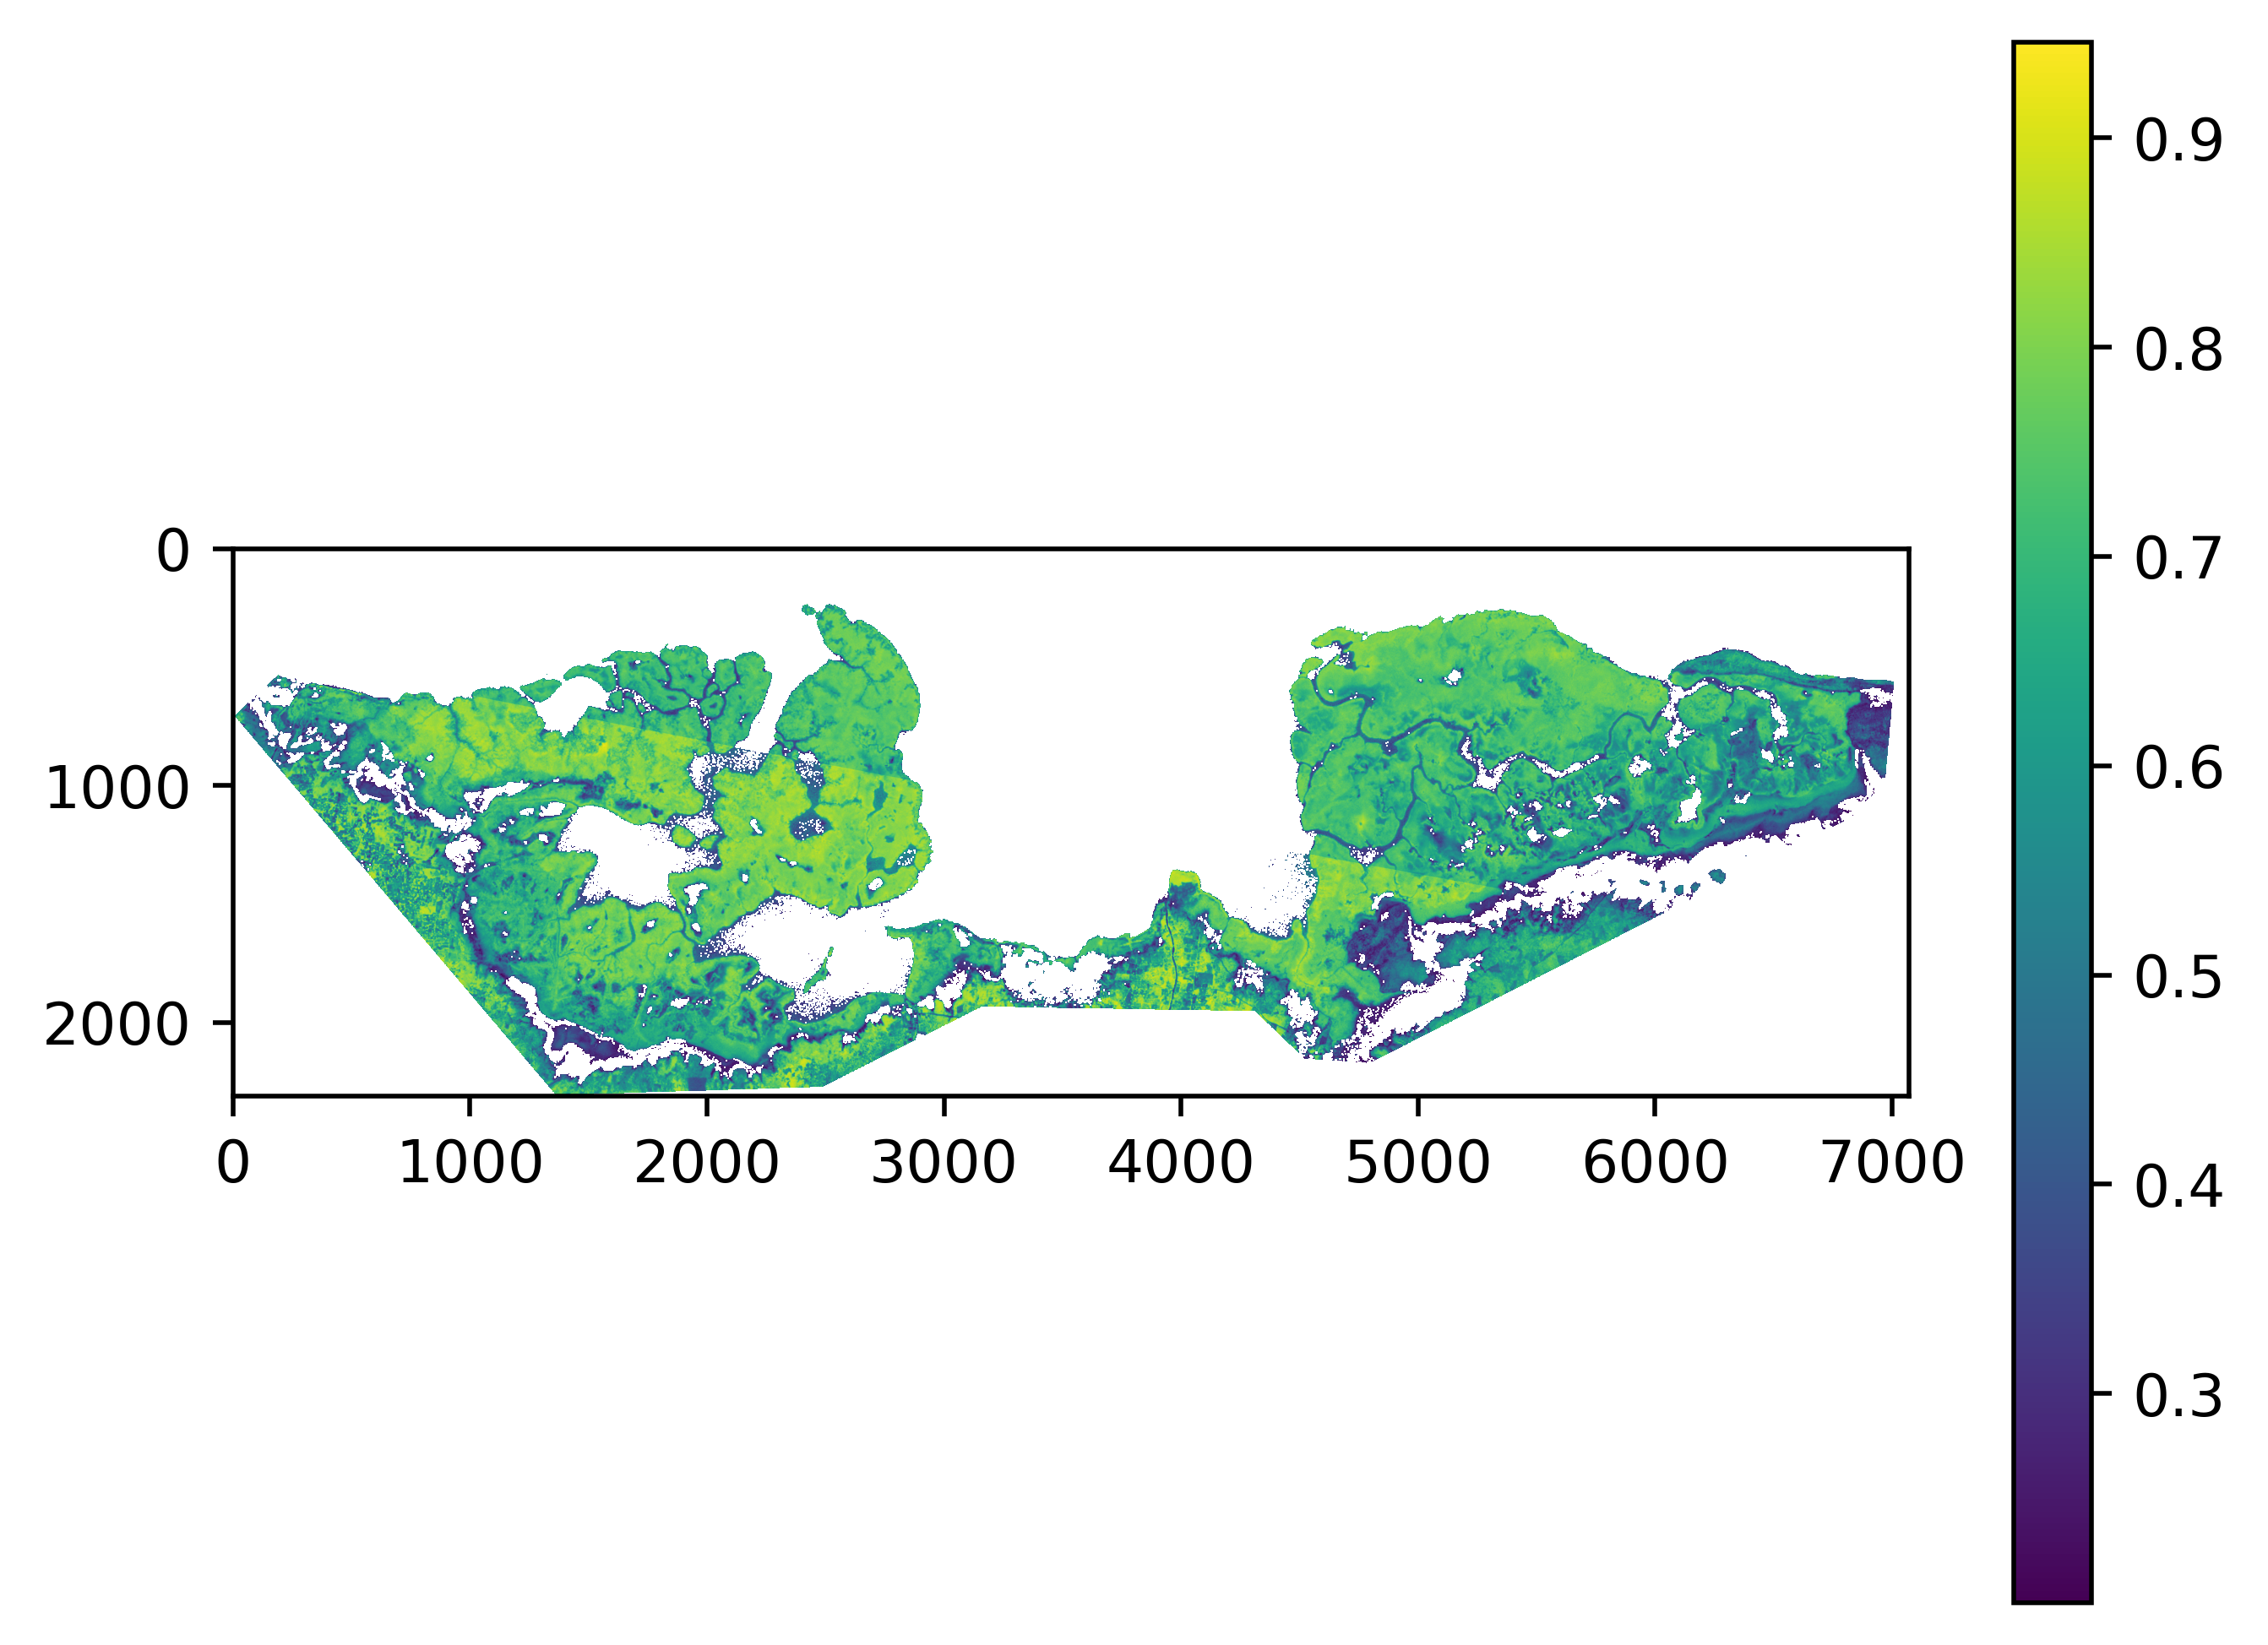

In [47]:
fig, ax = plt.subplots(dpi=500)
plt.imshow(test_vis[-1])
colorbar = plt.colorbar()

## Classification and Model Selection

Raster Samples and Label cleanup    

In [48]:
def label_clean(dataset, labels, times):
    samples_stack = labels.apply(lambda x: dataset[times[0]].rio.clip([x['geometry']], from_disk=True).squeeze().values, axis=1)
    labels['samples'] = samples_stack
    n = copy.deepcopy(labels)
    
    for time in times[1:]:
        print(f"Grabbing pixel values for labels at {time} observation.")
        obs = dataset[time]
        
        # Matching Label Points with Raster Pixels
        labels_n = labels.apply(lambda x: obs.rio.clip([x['geometry']], from_disk=True).squeeze().values, axis=1)
        # Samples for pixels changes every loop between observations while labelled point positions stay the same
        n['samples'] = labels_n
        labels = pd.concat([labels, n], ignore_index=True, axis=0)
    
    labels['samples'] = labels['samples'].apply(lambda x: x.reshape((1, -1)))
    # Finding out which data points exhibit a masked out feature (open water, urban, clouds)
    masked_points = labels['samples'].apply(lambda x: any(np.isnan(x[0])))

    # Replacing label in data points with NaNs with a new value (marked as their own 'unused' category)
    labels.loc[masked_points, 'id'] = 5

    return labels

<Axes: title={'center': 'band = 6, spatial_ref = 0'}, xlabel='x', ylabel='y'>

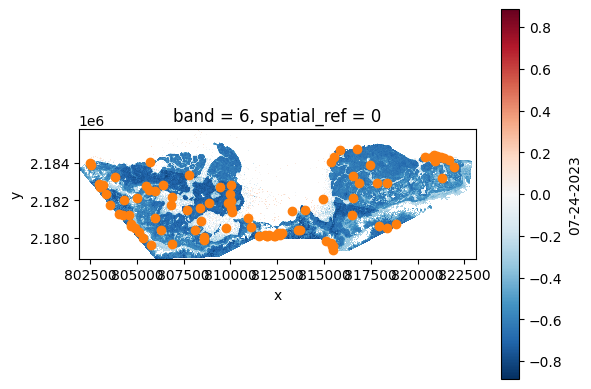

In [49]:
fig, ax = plt.subplots()
sites_data['CCHT']['dataset'][sites_data['CCHT']['dates'][0]][-2].plot(ax=ax)
sites_data['CCHT']['labels'].plot(ax=ax, color='tab:orange')

In [50]:
for code in site_codes:
    print('Getting samples for '+code)
    sites_data[code]['labels'] = label_clean(sites_data[code]['dataset'], sites_data[code]['labels'], sites_data[code]['dates'])

Getting samples for CCHT
Grabbing pixel values for labels at 08-31-2023 observation.
Grabbing pixel values for labels at 08-29-2023 observation.
Grabbing pixel values for labels at 09-03-2023 observation.
Grabbing pixel values for labels at 08-13-2023 observation.
Grabbing pixel values for labels at 08-05-2023 observation.
Grabbing pixel values for labels at 09-08-2023 observation.
Grabbing pixel values for labels at 07-31-2023 observation.
Grabbing pixel values for labels at 08-12-2023 observation.
Getting samples for GPHT
Grabbing pixel values for labels at 08-20-2023 observation.
Grabbing pixel values for labels at 08-13-2023 observation.
Grabbing pixel values for labels at 08-05-2023 observation.
Grabbing pixel values for labels at 08-21-2023 observation.
Grabbing pixel values for labels at 09-08-2023 observation.
Grabbing pixel values for labels at 07-28-2023 observation.
Grabbing pixel values for labels at 09-10-2023 observation.
Grabbing pixel values for labels at 09-01-2023 obs

Train-Test Split

In [51]:
def get_train_test_points(dataset, training_labels, times):
    X_data_train = []
    X_data_test = []
    labels_train = np.array([])
    labels_test = np.array([])

    # Train-Test Split
    train_set, test_set = train_test_split(training_labels, test_size=0.3, stratify=training_labels['id'])
    # Reshape data 
    new_train = []
    new_test = []
    temp_data_train = (train_set['samples']).apply(lambda x: x.reshape((1, -1)))
    temp_data_test = (test_set['samples']).apply(lambda x: x.reshape((1, -1)))
    for arr in temp_data_train.values:
        new_train.append(arr[0])
    for arr in temp_data_test.values:
        new_test.append(arr[0])    
    X_data_train = X_data_train + new_train
    X_data_test = X_data_test + new_test
        #X_data = X_data + new
        
        # getting labels repeated for every observation as they are unchanging with position
    labels_train = np.append(labels_train, train_set['id'].values)
    labels_test = np.append(labels_test, test_set['id'].values)

    # Putting train and test arrays together
    X_train = np.array(X_data_train)
    X_test = np.array(X_data_test)

    y_train = np.array(labels_train)
    y_test = np.array(labels_test)

    # Split data in train and test
    #X_data = np.array(X_data)
    #X_train, X_test, y_train, y_test = train_test_split(X_data, labels, test_size=0.3, stratify=labels)
    print(f"X_train Shape: {X_train.shape}\nX_test Shape: {X_test.shape} \ny_train Shape: {y_train.shape}\ny_test Shape:{y_test.shape}")
    return X_train, X_test, y_train, y_test, train_set, test_set

In [52]:
"""datasets = sites_data['CCHT']['dataset']
training_labels = sites_data['CCHT']['labels']
times = sites_data['CCHT']['dates']

X_data_train = []
X_data_test = []
labels_train = np.array([])
labels_test = np.array([])

    # Train-Test Split
train_set, test_set = train_test_split(training_labels, test_size=0.3, stratify=training_labels['id'])
train_set['samples'][0]"""

"datasets = sites_data['CCHT']['dataset']\ntraining_labels = sites_data['CCHT']['labels']\ntimes = sites_data['CCHT']['dates']\n\nX_data_train = []\nX_data_test = []\nlabels_train = np.array([])\nlabels_test = np.array([])\n\n    # Train-Test Split\ntrain_set, test_set = train_test_split(training_labels, test_size=0.3, stratify=training_labels['id'])\ntrain_set['samples'][0]"

In [53]:
X_train = np.array([])
X_test = np.array([])
y_train = np.array([])
y_test = np.array([])
test = []

X_train, X_test, y_train, y_test, train_set, test_set = get_train_test_points(sites_data[code]['dataset'], sites_data[code]['labels'], sites_data[code]['dates'])
for code in site_codes:
    ### CONCATENATE INSTEAD OF APPEND
    xtrain, xtest, ytrain, ytest, train_set, test_set = get_train_test_points(sites_data[code]['dataset'], sites_data[code]['labels'], sites_data[code]['dates'])
    X_train = np.concatenate((X_train, xtrain))
    X_test = np.concatenate((X_test, xtest))
    y_train = np.concatenate((y_train, ytrain))
    y_test = np.concatenate((y_test, ytest))

X_train Shape: (131, 7)
X_test Shape: (57, 7) 
y_train Shape: (131,)
y_test Shape:(57,)
X_train Shape: (573, 7)
X_test Shape: (246, 7) 
y_train Shape: (573,)
y_test Shape:(246,)
X_train Shape: (462, 7)
X_test Shape: (198, 7) 
y_train Shape: (462,)
y_test Shape:(198,)
X_train Shape: (131, 7)
X_test Shape: (57, 7) 
y_train Shape: (131,)
y_test Shape:(57,)


Stacking Image Data to be Trained On

In [54]:
shapes = sites_data['CCHT']['dataset'][sites_data['CCHT']['dates'][0]].shape
acq = [band.values.reshape(((band.shape)[0])*((band.shape)[1]), 1) for band in sites_data['CCHT']['dataset'][sites_data['CCHT']['dates'][0]]]
resh = np.array(acq).reshape(shapes[0], shapes[1]*shapes[2]).transpose()

In [55]:
train_set['id'].value_counts()

5    101
1     19
3      6
2      4
0      1
Name: id, dtype: int64

### Model Hyperparameter Tuning

In [56]:
param_grid = {
    'max_depth': [None, 10],
    'max_leaf_nodes': [15, 31],
    'learning_rate': [0.01, 0.1],
    'n_iter_no_change': [10, 20],
    'min_samples_leaf': [1, 10],
    'l2_regularization': [0, 1e-3, 1e-6],
    'class_weight': [{2:1.25, 1:0.25, 4:10}]
}

In [57]:
# Sentinel values in RF for NaNs
X_encoded = np.nan_to_num(X_train, nan=-99999) # Replace NaNs with a sentinel value
X_test_enc = np.nan_to_num(X_test, nan=-99999)

In [58]:
from sklearn.model_selection import RandomizedSearchCV

In [59]:
hgb_classifier = HistGradientBoostingClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)

grid_search = RandomizedSearchCV(
    estimator=hgb_classifier,
    param_distributions=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1,
)

grid_search.fit(X_encoded, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=HistGradientBoostingClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'class_weight': [{1: 0.25, 2: 1.25,
                                                          4: 10}],
                                        'l2_regularization': [0, 0.001, 1e-06],
                                        'learning_rate': [0.01, 0.1],
                                        'max_depth': [None, 10],
                                        'max_leaf_nodes': [15, 31],
                                        'min_samples_leaf': [1, 10],
                                        'n_iter_no_change': [10, 20]},
                   scoring='accuracy', verbose=1)

In [60]:
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

Best Parameters: {'n_iter_no_change': 10, 'min_samples_leaf': 1, 'max_leaf_nodes': 31, 'max_depth': 10, 'learning_rate': 0.1, 'l2_regularization': 0, 'class_weight': {2: 1.25, 1: 0.25, 4: 10}}
Best Accuracy: 0.9113335313335315


In [61]:
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test_enc, y_test)
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.9301075268817204


### Prediction and Visualization of Whole Site

In [62]:
resh = np.nan_to_num(resh, nan=-99999)
hgb_pred = best_model.predict(resh)

In [63]:
hgb_classified = hgb_pred.reshape(shapes[1], shapes[2])
hgb_classified = cv.GaussianBlur(hgb_classified.astype(np.uint8), (3,3), 0)

In [64]:
custom_cmap = colors_mat.ListedColormap(colors=['mediumseagreen', 'forestgreen', 'tan', 'lightsteelblue', 'gray', 'white'])
boundaries = [0, 1, 2, 3, 4, 5]
custom_norm = colors_mat.BoundaryNorm(boundaries, custom_cmap.N, clip=True)

patches = [mpatches.Patch(color='gray', label='Urban'),
           mpatches.Patch(color='mediumseagreen', label='Other Vegetation'),
           mpatches.Patch(color='forestgreen', label='Mangrove'),
           mpatches.Patch(color='tan', label='Mud Flat'),
           mpatches.Patch(color='lightsteelblue', label='Water, Intertidal Zone, and Mudflats'),
           ]

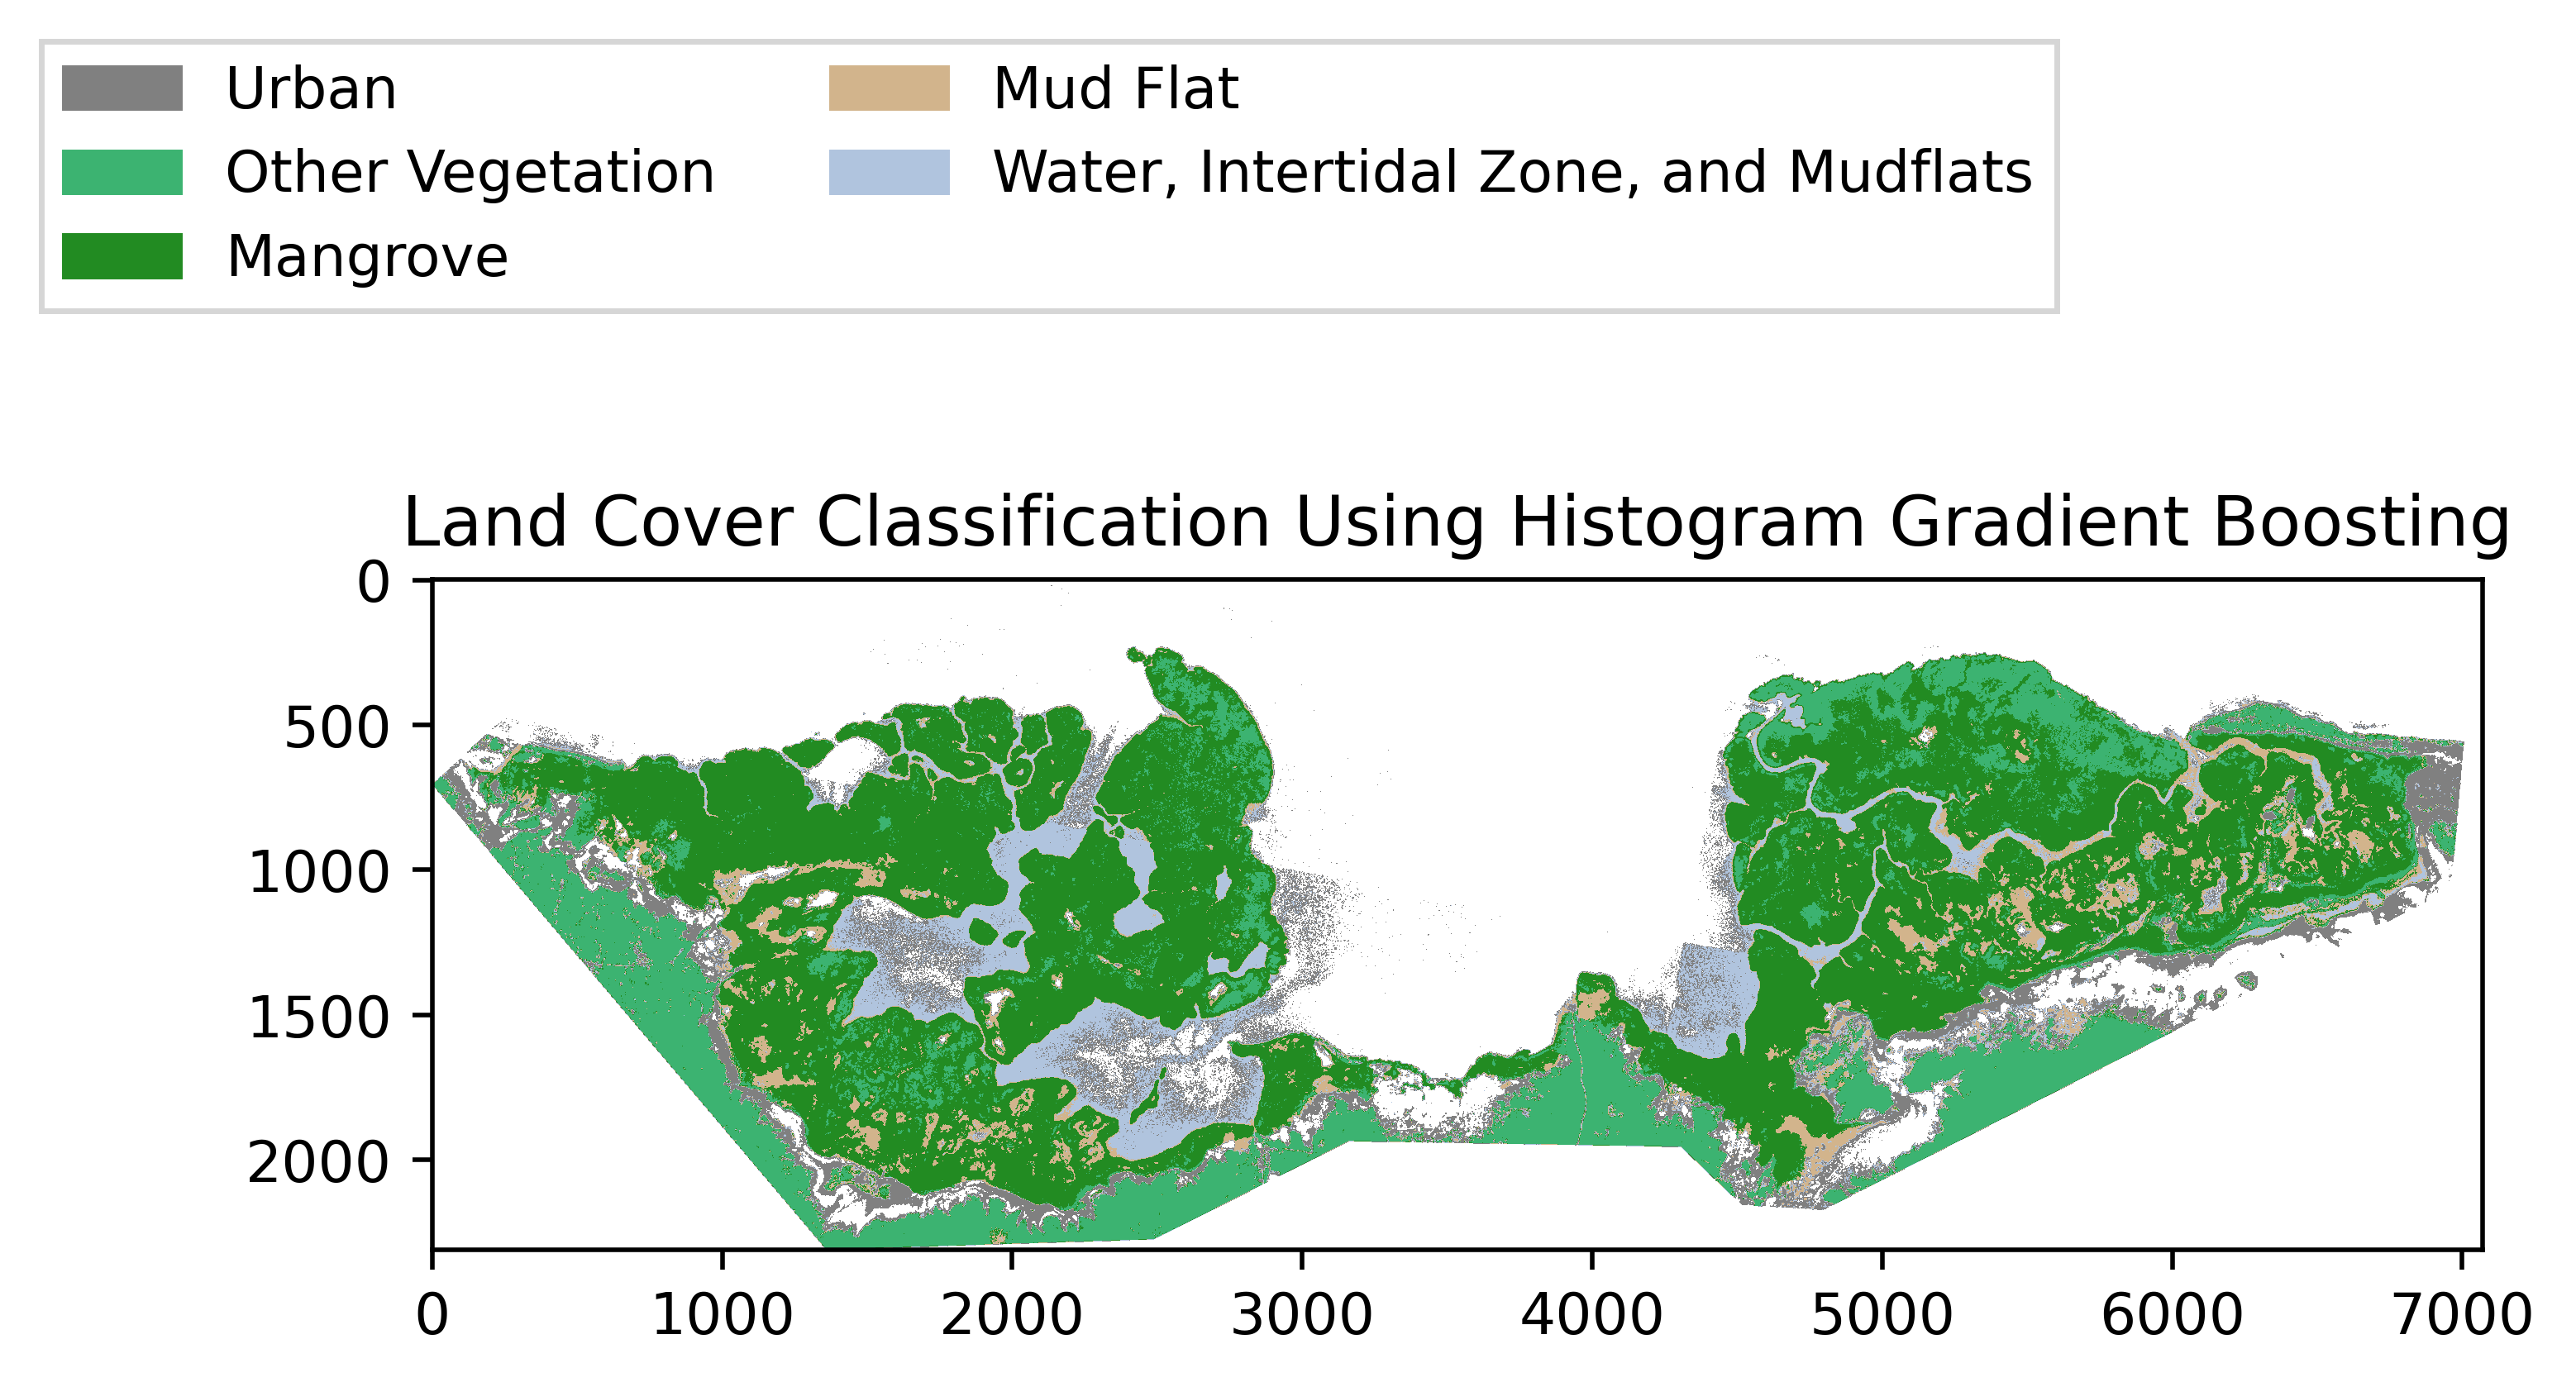

In [65]:
fig, ax = plt.subplots(dpi=500)
ax.imshow(hgb_classified, cmap=custom_cmap)
fig.legend(handles=patches, fancybox=False, bbox_to_anchor=(0.75,0.95), ncol=2)
ax.set_title('Land Cover Classification Using Histogram Gradient Boosting')
#fig.patch.set_facecolor('xkcd:white')
plt.show()

## Dumping Model for Classification Use

In [66]:
dump(best_model, '../'+CLASSIFIER_PATH)

['../models/hgb_retrained.joblib']